In [2]:
import pandas as pd
import jqdatasdk as jq
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.decomposition import PCA
from sklearn import preprocessing

In [3]:
# jq.auth('13918852005','jxjslsc,.?2')
jq.auth('15123395860','395860')

auth success  - 聚宽高频因子挖掘挑战赛正式启动。快来参赛获得认证证书、正式&实习Offer、奖金等，详情查看大赛官方网页：http://t.cn/EowDwNU


In [51]:
industryDrinkFood2017 = jq.get_industry_stocks('801120', date='2011-01-01')

In [141]:
cnt = 0
for code in industryDrinkFood2017:
    trade_data = jq.get_price(code, start_date='2011-01-01',
                              end_date='2019-05-17',
                              frequency='daily',
                              fields=None, 
                              skip_paused=False, 
                              fq='pre', 
                              count=None)
    
    df_temp_price = trade_data[['close']]
    df_temp_price.columns = [code]
    
    df_temp_volume = trade_data[['volume']]
    df_temp_volume.columns = [code]
    
    if cnt == 0:
        priceData = df_temp_price
        volumeData = df_temp_volume
    else:
        priceData=pd.concat([priceData,df_temp_price],axis=1)
        volumeData=pd.concat([volumeData,df_temp_volume],axis=1)
        
    cnt+=1
priceData.to_csv('C:/Users/jxjsj/Desktop/DataDownload/QuantData/priceData.csv',index=True)
volumeData.to_csv('C:/Users/jxjsj/Desktop/DataDownload/QuantData/volumeData.csv',index=True)

In [3]:
priceData=pd.read_csv('C:/Users/jxjsj/Desktop/DataDownload/QuantData/priceData.csv',index_col=0)
volumeData=pd.read_csv('C:/Users/jxjsj/Desktop/DataDownload/QuantData/volumeData.csv',index_col=0)

In [58]:
rData = (np.log(priceData) - np.log(priceData.shift(1))).dropna()

                            OLS Regression Results                            
Dep. Variable:            600519.XSHG   R-squared:                       0.932
Model:                            OLS   Adj. R-squared:                  0.932
Method:                 Least Squares   F-statistic:                 2.774e+04
Date:                Sat, 18 May 2019   Prob (F-statistic):               0.00
Time:                        16:54:03   Log-Likelihood:                -11125.
No. Observations:                2034   AIC:                         2.225e+04
Df Residuals:                    2032   BIC:                         2.226e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         -77.7095      2.558    -30.384      

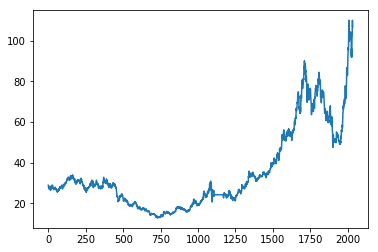

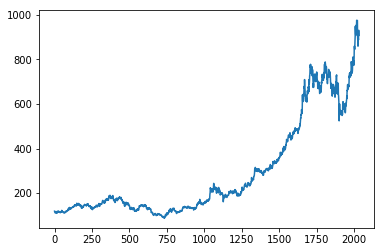

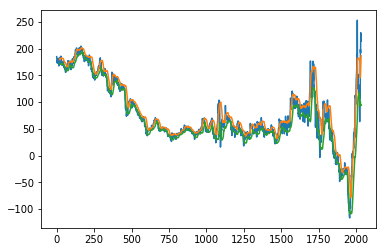

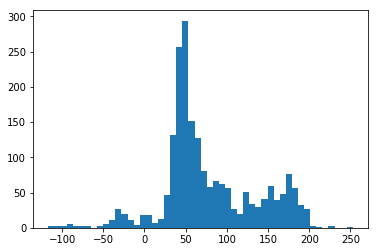

In [22]:
### 最大相关性，价差序列构造 ###
dfUsed = priceData
# dfUsed = volumeData

corrMatrix = dfUsed.corr()
corrMatrix = corrMatrix.replace([1.],[0])

# 最大值对
code1, code2 = corrMatrix.max().idxmax(),corrMatrix.idxmax()[corrMatrix.max().idxmax()]

pair1P = dfUsed[code1]
pair2P = dfUsed[code2]

X = pair1P
y = pair2P
X = sm.add_constant(X)
est = sm.OLS(y,X)
result = est.fit()

print(result.summary())

series = pair1P*result.params[1]-pair2P

plt.plot(pair1P.values)
plt.show()
plt.plot(pair2P.values)
plt.show()

plt.plot(series.values)
plt.plot(series.rolling(20).mean().values+series.rolling(20).std().values)
plt.plot(series.rolling(20).mean().values-series.rolling(20).std().values)
plt.show()

plt.hist(series.values,50)
plt.show()

In [4]:
### 寻找协整关系，找出配对 ###

import itertools
list1 = priceData.columns
list2 = []
# for i in range(1,len(list1)+1):
#     iter_ = itertools.combinations(list1,i)
#     if i ==1:
#         iter_ = [[i[0]] for i in iter_]
#     else:
#         iter_ = [list(i) for i in iter_]
#     list2.append(list(iter_))

# 寻找所有的两两对
iter_ = itertools.combinations(list1,2)
iter_ = [list(i) for i in iter_]
list2.append(list(iter_))

pairList = list2[0]

pairPvalue = pd.DataFrame(index=range(len(pairList)),columns=['pair1','pair2','pvalue'])

# 对所有两两对进行协整关系检验，很慢！
cnt = 0
for pairs in pairList:
    
    pair1 = pairs[0]
    pair2 = pairs[1]
    
    data1 = priceData[pair1]
    data2 = priceData[pair2]
    
    result = sm.tsa.stattools.coint(data1, data2)
    
    pvalue = result[1]
    
    pairPvalue.iloc[cnt,] = pair1,pair2,pvalue
    
    cnt+=1
    print("%.4f%%" %(cnt/len(pairList)*100),end='\r')

In [5]:
pairPvalue.to_csv('C:/Users/jxjsj/Desktop/DataDownload/QuantData/pairPvalue.csv',index=True)

In [4]:
pairPvalue = pd.read_csv('C:/Users/jxjsj/Desktop/DataDownload/QuantData/pairPvalue.csv',index_col=0)

In [ ]:
# 价差序列是由全时段构造的，存在未来函数的情况

In [98]:
# 对具有最强协整关系的股票对构造组合
pairPvalueSort = pairPvalue.sort_values('pvalue')

TOPN = 5
# TOPN = len(pairPvalueSort)

tradeMeanCollectin = []
tradeStdCollectin = []

saveCode=[]

for topn in range(TOPN):
    print('----------',topn+1,'----------')
    code1, code2, pvalue = pairPvalueSort.iloc[topn,0],pairPvalueSort.iloc[topn,1],pairPvalueSort.iloc[topn,2]

    pair1P = priceData[code1]
    pair2P = priceData[code2]

    # 回归确定价差
#     X = pair1P
#     y = pair2P
#     X = sm.add_constant(X)
#     est = sm.OLS(y,X)
#     result = est.fit()
#     series = pair1P*result.params[1]-pair2P

    # 最简单的价差
    series = pair1P - pair2P

    # 绘图
#     plt.plot(pair1P.values)
#     plt.show()
#     plt.plot(pair2P.values)
#     plt.show()

#     plt.plot(series.values)
#     plt.plot(series.rolling(20).mean().values+series.rolling(20).std().values)
#     plt.plot(series.rolling(20).mean().values-series.rolling(20).std().values)
#     plt.show()

#     plt.hist(series.values,50)
#     plt.show()

    # ADF-test
#     result = sm.tsa.stattools.adfuller(series)
#     print(result[1])

    # 75%法则检验，价差有75%概率向靠近中位数的方向移动
    ## 中位数取大量数据中位数
    deltaPriceAndMedian = pd.concat([series.expanding().median(),series],axis=1)
#     deltaPriceAndMedian = pd.concat([series.rolling(20).median(),series],axis=1).dropna()
    deltaPriceAndMedian.columns = ['deltaPriceMedian','deltaPrice']
    deltaPriceAndMedian['deltaPriceShift'] = deltaPriceAndMedian['deltaPrice'].shift(-1) - deltaPriceAndMedian['deltaPrice']
#     # 总概率
#     deltaPriceAndMedian75P = deltaPriceAndMedian[((deltaPriceAndMedian.deltaPrice<deltaPriceAndMedian.deltaPriceMedian) & (deltaPriceAndMedian.deltaPriceShift>0)) | ((deltaPriceAndMedian.deltaPrice>deltaPriceAndMedian.deltaPriceMedian) & (deltaPriceAndMedian.deltaPriceShift<0))]
#     prob = len(deltaPriceAndMedian75P)/len(deltaPriceAndMedian)
#     # 单边概率，当日小于中位数
#     deltaPriceAndMedianSM = deltaPriceAndMedian[((deltaPriceAndMedian.deltaPrice<deltaPriceAndMedian.deltaPriceMedian))]
#     deltaPriceAndMedianSM75P = deltaPriceAndMedian[((deltaPriceAndMedian.deltaPrice<deltaPriceAndMedian.deltaPriceMedian) & (deltaPriceAndMedian.deltaPriceShift>0))]
#     probSM = len(deltaPriceAndMedianSM75P)/len(deltaPriceAndMedianSM)
#     # 单边概率，当日大于中位数
#     deltaPriceAndMedianBM = deltaPriceAndMedian[((deltaPriceAndMedian.deltaPrice>deltaPriceAndMedian.deltaPriceMedian))]
#     deltaPriceAndMedianBM75P = deltaPriceAndMedian[((deltaPriceAndMedian.deltaPrice>deltaPriceAndMedian.deltaPriceMedian) & (deltaPriceAndMedian.deltaPriceShift<0))]
#     probBM = len(deltaPriceAndMedianBM75P)/len(deltaPriceAndMedianBM)
    
#     plt.plot(deltaPriceAndMedian.deltaPrice.values)
#     plt.plot((deltaPriceAndMedian.deltaPrice.rolling(60).mean()+deltaPriceAndMedian.deltaPrice.rolling(60).std()).values)
#     plt.plot((deltaPriceAndMedian.deltaPrice.rolling(60).mean()-deltaPriceAndMedian.deltaPrice.rolling(60).std()).values)
#     plt.plot(deltaPriceAndMedian.deltaPriceMedian.values)
#     plt.show()
    
    # 构造配对交易投资组合，高于中位数反向，低于中位数正向，获得收益率序列
    deltaPriceAndMedianTrade = deltaPriceAndMedian.iloc[:-1,:]
    deltaPriceAndMedianTrade.index = rData.index
    rDataC1C2 = rData[[code1,code2]]
    rDataC1C2.columns = ['code1','code2']
    pairTrade = pd.concat([deltaPriceAndMedianTrade,rDataC1C2],axis=1)
    pairTradeR = pairTrade.apply(lambda x: x['code2']-x['code1'] if x['deltaPrice']>x['deltaPriceMedian'] else -x['code2']+x['code1'],axis=1)
#     plt.plot(pairTradeR.values)
#     plt.show()
    
#     print('TolProb',prob)
#     print('SMProb',probSM)
#     print('BMProb',probBM)
    print('PairTradeMean',pairTradeR.mean())
    print('PairTradeStd',pairTradeR.std())
    
    tradeMeanCollectin.append(pairTradeR.mean())
    tradeStdCollectin.append(pairTradeR.std())
    

    # 找出不满足75%法则的价差对应的股票对
#     if prob<0.6:
#         saveCode.append(code1)
#         saveCode.append(code2)
    
    ## 中位数取固定（可变）周期数据中位数
#     maxProb = 0
#     maxWindow = 0
#     for window in range(50,1000,50):
#         sumNum += 1
#         deltaPriceAndMedian = pd.concat([series.rolling(window).median(),series],axis=1).dropna()
#         deltaPriceAndMedian.columns = ['deltaPrice','deltaPriceMedian']
#         deltaPriceAndMedian['deltaPriceShift'] = deltaPriceAndMedian['deltaPrice'].shift(-1) - deltaPriceAndMedian['deltaPrice']
#         deltaPriceAndMedian75P = deltaPriceAndMedian[((deltaPriceAndMedian.deltaPrice<deltaPriceAndMedian.deltaPriceMedian) & (deltaPriceAndMedian.deltaPriceShift>0)) | ((deltaPriceAndMedian.deltaPrice>deltaPriceAndMedian.deltaPriceMedian) & (deltaPriceAndMedian.deltaPriceShift<0))]
#         prob = len(deltaPriceAndMedian75P)/len(deltaPriceAndMedian)
#         sumProb += prob
#         if prob > maxProb:
#             maxProb = prob
#             maxWindow = window
#     print(maxProb,maxWindow)
    
#     print('%.4f%%'%(len(deltaPriceAndMedian75P)/len(deltaPriceAndMedian)*100))

---------- 1 ----------
PairTradeMean 0.0011818666855481325
PairTradeStd 0.03568384626266812
---------- 2 ----------
PairTradeMean 0.0010498771575558517
PairTradeStd 0.03087843884771672
---------- 3 ----------
PairTradeMean 0.0015193240688003856
PairTradeStd 0.03141572950852864
---------- 4 ----------
PairTradeMean 0.001719442085461137
PairTradeStd 0.03540928296947553
---------- 5 ----------
PairTradeMean 0.0019497525792057408
PairTradeStd 0.033878907895335306


0.14840525153142498


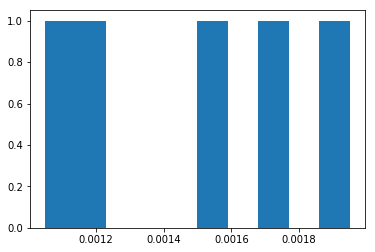

In [99]:
plt.hist(tradeMeanCollectin)
print(np.mean(tradeMeanCollectin)*100)
plt.show()

In [71]:
pairTrade

,deltaPriceMedian,deltaPrice,deltaPriceShift,code1,code2
2011-01-05,2.055190,2.055190,-0.048659,-0.017110,-0.013889
2011-01-06,2.030860,2.006530,0.032908,0.009941,0.006969
2011-01-07,2.039439,2.039439,-0.022876,-0.003604,0.000000
2011-01-10,2.028001,2.016563,0.055622,-0.018215,-0.040147
2011-01-11,2.039439,2.072184,-0.010130,-0.026072,-0.036814
2011-01-12,2.047314,2.062055,-0.008562,0.001885,0.004988
2011-01-13,2.053493,2.053493,0.014314,0.005634,0.004963
2011-01-14,2.054341,2.067806,0.059935,-0.013195,-0.035268
2011-01-17,2.055190,2.127741,-0.124508,-0.046610,-0.039221
2011-01-18,2.054341,2.003233,0.080032,0.006934,-0.010724


In [12]:
# 找出 与大部分股票的价差 无 向中位数回归 特性的股票
saveCodeDict={}
for i in saveCode:
    try:
        saveCodeDict[i]+=1
    except:
        saveCodeDict[i]=1

(2033, 57)
(2033, 5)
各主成分贡献度:[0.38664752 0.06296796 0.02702668 0.0242479  0.01822068]


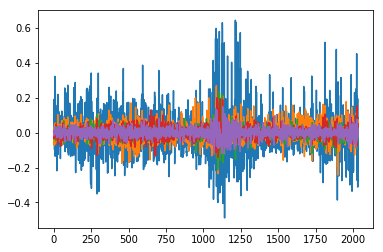

In [21]:
### 因子分析 ###
rData = (np.log(priceData) - np.log(priceData.shift(1))).dropna()
n_components=5

# rData = preprocessing.scale(rData)
pca = PCA(n_components=n_components)
rData_p= pca.fit(rData).transform(rData)
print(rData.shape)  #原始变量维度
print(rData_p.shape)#主成分变量的维度

print('各主成分贡献度:{}'.format(pca.explained_variance_ratio_))

for i in range(n_components):
    plt.plot(rDataScale_p[:,i])